# Corrección de distorción de cámara y calibración con OpenCV

En esta práctica, se aprenderá sobre los tipos de distorsión causados por las cámaras, cómo encontrar las propiedades intrínsecas y extrínsecas de una cámara, cómo deshacer la distorsión de las imágenes basándose en estas propiedades.

#### Importar librerías y funciones auxiliares

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

plt.style.use('dark_background')

def plot_img(images, titles):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images), figsize = (15, 15))
  for i, p in enumerate(images):
    axs[i].imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])
    axs[i].axis('off')
  plt.show()

## Calibración de cámaras

Una cámara es un componente crucial en varios campos, como la robótica y la exploración espacial. Es útil para numerosos análisis y ayuda a registrar cada momento. Debemos conocer las especificaciones de la cámara para utilizarla como sensor visual. La <b>calibración de la cámara</b> no es más que la estimación de sus parámetros, para determinar con precisión la relación entre un punto 3D del mundo real y su correspondiente proyección 2D (píxel) en la imagen captada por esa cámara calibrada.

Debemos tener en cuenta tanto los factores internos, como la distancia focal, el centro óptico y los coeficientes de distorsión radial del objetivo, como los factores externos, como la rotación y la traslación de la cámara con respecto a un sistema de coordenadas externo.

<center><img src='Recursos\Intrinseco_Extrinseco.png' width='500'></center>

### Funcionamiento de una cámara (modelo <i>pinhole</i>)

Todas las cámaras, viejas y nuevas, funcionan bajo el mismo principio: la luz reflejada por el sujeto entra por un agujero y proyecta una imagen en la parte posterior de la cámara. A partir de ahí, es detectada por un material sensible a la luz (ya sea un sensor digital o una película).

En una cámara ideal (estenopeica), cuando la apertura de la cámara se representa como un punto y no se emplean lentes para concentrar la luz, el modelo de cámara ilustra la relación matemática entre las coordenadas de un punto en el espacio tridimensional y su proyección en el plano de la imagen. El modelo <b>NO</b> incluye efectos como las <i>distorsiones geométricas</i> o el <i>desenfoque de los objetos</i> desenfocados provocados por las lentes y las aberturas con tamaños fijos. Además, ignora el hecho de que la mayoría de las cámaras del mundo real sólo pueden capturar coordenadas de imagen discretas.

<center><img src='Recursos\pinhole.jpg' width='500'></center>
<figcaption>Imagen: Wikimedia Commons</figcaption>

#### Lentes

Las cámaras tienen lentes, a diferencia de las estenopeicas. Para obtener una imagen nítida y enfocada, los objetivos suelen tener varios elementos de cristal que desvían la luz. La cantidad de cristal, su disposición y la calidad del mismo influyen en la calidad de la imagen final. Una de las razones por las que algunos objetivos son más caros que otros se debe a esto. La imagen se puede enfocar desplazando el cristal del objetivo. También se puede modificar la distancia focal en algunos objetivos (zoom).

<center><img src='Recursos\lentes.jpg' height='300'></center>

### Parametros intrinsecos

Las características de la cámara que crea en la realidad están definidas por estos atributos intrínsecos:

#### Apertura

Los objetivos modernos tienen un diafragma, que es un agujero que deja pasar la luz. Al igual que las pupilas de nuestros ojos se expanden o contraen para dejar pasar más o menos luz, la mayoría de las cámaras permiten ajustar el tamaño de la apertura.

<center><img src='Recursos\apertura.jpg' width='500'></center>

Se debe de tomar en cuenta que la apertura se expresa en números f, así: f/1,8, f/2,8, f/6,3, f/9, f/16, etc., donde los números f más pequeños corresponden a aperturas mayores.

#### Distancia focal

La distancia focal de un sistema óptico sirve para medir la intensidad con la que diverge o converge la luz. Es la potencia óptica de la inversa del sistema. Se dice que un sistema con una distancia focal positiva hace converger la luz, y uno con una distancia focal negativa hace divergir la luz.

<center><img src='Recursos\distancia focal.jpg' width='600'></center>
<figcaption>Imagen: SeeedStudio</figcaption>

La distancia focal $f$, la distancia del objeto a la lente $u$ y la distancia de la lente a la imagen $v$ están relacionadas cuando se utiliza una lente para crear una imagen de un objeto, y es descrita matematicamente por la siguiente ecuación:

$
\frac{1}{f} = \frac{1}{u} + \frac{1}{v}
$

Aunque los lentes más antiguos pueden estar etiquetados en centímetros (cm) o en pulgadas, las distancias focales de los lentes de las cámaras actuales se suelen medir en milímetros (mm). La relación entre el campo de visión (FOV) de un objetivo y la distancia focal (f) es inversa.

<center><img src='Recursos\FOV distancia focal.jpg' height='500'></center>
<figcaption>Imagen: 365Enfoques</figcaption>

El aumento con el que un objetivo fotografía objetos lejanos depende de su distancia focal. Equivale a la separación entre el plano de la imagen y un <i>pinhole</i> que puede capturar objetos lejanos que tienen el mismo tamaño que el objetivo.

<center><img src='Recursos\distancia focal distorcion.gif' height='500'></center>
<figcaption>Imagen: SharkD</figcaption>

### Aberraciones ópticas

En el campo de la óptica, la aberración es una característica de los sistemas ópticos, como las lentes, que hace que la luz se disperse en una amplia zona del espacio en lugar de enfocarse en un solo punto. Según el tipo de aberración, el desenfoque o la distorsión de la imagen creada por el objetivo se debe a las aberraciones. Existen multiples tipos de aberraciones ópticas, pero en esta práctica nos enfocaremos en las distorciones provocadas por lentes.

En fotografía, la distorsión se conoce normalmente como una aberración óptica que dobla y deforma las líneas físicamente rectas para darles la apariencia de ser curvas en las imágenes, por lo que este tipo de distorsión también se denomina frecuentemente "curvilínea". Cuando se emplean elementos de lente únicos en el diseño óptico para disminuir las aberraciones esféricas y de otro tipo, se produce una distorsión óptica. Una distorsión óptica es, en esencia, un error de la lente.

La distorción de barril, distorción de cojín y la distorción de bigote son los tres tipos reconocidos de distorsión óptica.

#### Distorción de barril

El término "distorsión de barril" se refiere a una forma de aberración en la que las líneas rectas se doblan hacia dentro en forma de barril. Los objetivos gran angular suelen presentar distorsión de barril porque el campo de visión del objetivo es mucho más amplio que el tamaño del sensor de imagen, por lo que hay que "apretarlo" para que encaje. Como resultado, especialmente hacia los márgenes más lejanos del encuadre, las líneas rectas se doblan claramente hacia dentro. Un ejemplo de una fuerte distorsión de barril se muestra a continuación:

<center><img src='Recursos\distorcion barril.jpg' height='400'></center>
<figcaption>Imagen: photographylife</figcaption>

Las líneas son rectas en el centro exacto del encuadre y sólo comienzan a arquearse fuera de él. Esto se debe a que la imagen es la misma en el eje óptico, o el centro del objetivo, pero que su aumento disminuye hacia las esquinas.

#### Distorción de cojín

En la distorsión de cojín, las líneas rectas se doblan hacia fuera desde el centro, exactamente lo contrario de la distorsión de barril. Este tipo de distorsión se observa con frecuencia en los teleobjetivos y se desarrolla a medida que el aumento de la imagen se aleja del eje óptico y se acerca a la periferia del encuadre. En esta ocasión, es necesario "estirar" el campo de visión para que encaje, ya que es menor que el tamaño del sensor de imagen. Así, las líneas rectas parecen ser arrastradas hacia arriba en las esquinas, como se muestra a continuación:

<center><img src='Recursos\distorcion cojin.jpg' height='400'></center>
<figcaption>Imagen: photographylife</figcaption>

Debemos calibrar la cámara para recibir en ella una representación exacta del entorno real. Necesitamos tener la seguridad de que el tamaño de un objeto en el mundo real se corresponde con un tamaño concreto en coordenadas de píxeles de la cámara.

Para estimar los parámetros extrínsecos (vectores de rotación y traslación) e intrínsecos (como la distancia focal, el centro óptico, etc.) del objetivo y el sensor de imagen de una cámara con el fin de reducir el error de distorsión provocado por los defectos de la cámara, un método consiste en calibrar la cámara utilizando un patrón conocido del mundo real, como un tablero de ajedrez.

### Detección de tableros de ajedrez

Un método habitual para llevar a cabo la calibración de cámaras y determinar los valores de los parámetros desconocidos es la calibración de tableros de ajedrez. Debido a su geometría altamente organizada y a su idoneidad para la detección y el procesamiento algorítmicos, los tableros de ajedrez aparecen con frecuencia en la teoría y la práctica de la visión por ordenador. Hay dos componentes principales en la formación de tableros de ajedrez en la visión por ordenador: la extracción de características y la calibración de la cámara.

<center><img src='Recursos\Chess.jpg' height='400'></center>

El paquete de calibración del tablero de ajedrez en OpenCV hace un esfuerzo por convertir los puntos 3D del tablero de ajedrez en coordenadas 2D de la cámara. La distorsión se corrige entonces utilizando esta información.

Aunque se puede utilizar cualquier objeto (un libro, una laptop, un coche, etc.), un tablero de ajedrez tiene ciertas cualidades que lo hacen ideal para la tarea de eliminar las distorsiones de la cámara:

<ul>
<li> Es plano, por lo que no necesitas ocuparte del eje z (z=0), sólo de los ejes x e y. Todos los puntos del tablero se encuentran en el mismo plano.
<li> Hay esquinas y puntos claros, lo que facilita la asignación de puntos del sistema de coordenadas 3D del mundo real a puntos del sistema de coordenadas de píxeles 2D de la cámara.
<li> Los puntos y las esquinas se sitúan en líneas rectas.
</ul>

#### Deteccion de tablero de ajedrez en OpenCV

Por lo tanto, podemos utilizar la función `cv2.findChessboardCorners()` para encontrar un patrón en el tablero de ajedrez. Esta funcion devuelve los puntos de las esquinas y una respuesta que es `True` si se alcanza el patrón deseado. Dispondremos estas esquinas en un orden determinado (de izquierda a derecha, de arriba a abajo).

#### Sintaxis de Función

``` python
retval, corners = cv2.findChessboardCorners(image, patternSize, corners, flags)
```

`retval`: Si se localizan todas las esquinas y se ordenan en una secuencia determinada, el método devuelve un `True` (fila por fila, de izquierda a derecha en cada fila). En caso contrario, el método devuelve `False` si no es capaz de localizar todas las esquinas o reordenarlas.<br>

`corners`: Matriz de salida de las esquinas detectadas.

La función tiene **3 argumentos de entrada requeridos** y algunas banderas:
<ol>
    <li><code>img</code>: Vista del tablero de origen. Debe ser una imagen de 8 bits en escala de grises o en color. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>patternSize</code>: Número de esquinas interiores por fila y columna de un tablero de ajedrez. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>corners</code>: Matriz de salida de las esquinas detectadas. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>flags</code>: Varios indicadores de operación que pueden ser cero o una combinación de alguna de las siguientes banderas:</li>
        <ul>
        <b>Banderas</b>
        <li><b><code>CALIB_CB_ADAPTATIVE_THRESH</code></b>: Utiliza el umbral adaptativo para convertir la imagen a blanco y negro, en lugar de un nivel de umbral fijo (calculado a partir del brillo medio de la imagen).
        <li><b><code>CALIB_CB_NORMALIZE_IMAGE</code></b>: Normaliza la gamma de la imagen con <code>cv2.equalizeHist()</code> antes de aplicar el umbral fijo o adaptativo.
        <li><b><code>CALIB_CB_FAST_CHECK</code></b>: Ejecuta una comprobación rápida en la imagen que busque esquinas de tablero de ajedrez y acorte la llamada si no encuentra ninguna. Esto puede acelerar drásticamente la llamada en la condición cuando no se observa ningún tablero de ajedrez.
        </ul>
</ol>

Una vez encontradas las esquinas, podemos aumentar su precisión utilizando <code>cv2.cornerSubPix()</code>.

#### Sintaxis de Función

``` python
corners = cv2.cornerSubPix(image, corners, winSize, zeroZone, criteria)
```

`corners`: Matriz de salida de las esquinas detectadas refinadas.

La función tiene **5 argumentos de entrada requeridos**:

<ol>
    <li><code>image</code>: Entrada de imagen monocanal, de 8 bits o flotante. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>corners</code>: Coordenadas iniciales de las esquinas de entrada y coordenadas refinadas proporcionadas para la salida. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>winSize</code>: La mitad de la longitud lateral de la ventana de búsqueda. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>zeroZone</code>: La mitad del tamaño de la región muerta en medio de la zona de búsqueda sobre la que no se realiza la suma. Se utiliza a veces para evitar posibles singularidades de la matriz de autocorrelación. El valor de (-1,-1) indica que no existe tal tamaño. Es un argumento <b>obligatorio</b>.
    <li><code>criteria</code>: Criterios para la terminación del proceso iterativo de refinamiento de esquinas. Es decir, el proceso de refinamiento de la posición de la esquina se detiene después de <code>criteria.maxCount</code> iteraciones o cuando la posición de la esquina se mueve por menos de <code>criteria.epsilon</code> en alguna iteración. Es un argumento <b>obligatorio</b>.
</ol>

También podemos dibujar el patrón utilizando <code>cv2.drawChessboardCorners()</code>. La función dibuja las esquinas individuales del tablero de ajedrez detectadas como círculos rojos si no se encontró el tablero, o como esquinas coloreadas conectadas con líneas si se encontró el tablero.

#### Sintaxis de Función

``` python
image = cv2.drawChessboardCorners(image, patternSize, corners, patternWasFound)
```

`image`: Imagen de destino. Debe ser una imagen en color de 8 bits.

La función tiene **4 argumentos de entrada requeridos**:

<ol>
    <li><code>image</code>: Entrada de imagen a color de 8 bits. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>patternSize</code>: Número de esquinas interiores por fila y columna de un tablero de ajedrez. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>corners</code>: Matriz de esquinas detectadas, el resultado de <code>cv2.findChessboardCorners()</code> o <code>cornerSubPix()</code> (en caso de que se haya hecho un refinamiento). Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>patternWasFound</code>: Parámetro que indica si se ha encontrado el tablero completo o no. El valor de retorno de <code>cv2.findChessboardCorners()</code> debe pasarse aquí. Es un argumento <b>obligatorio</b>.
</ol>

Todos el procedimiento para la deteccion se muestra de manera simplificada en el siguiente código:

Text(0.5, 1.0, 'Deteccion de esquinas de tablero de ajedrez')

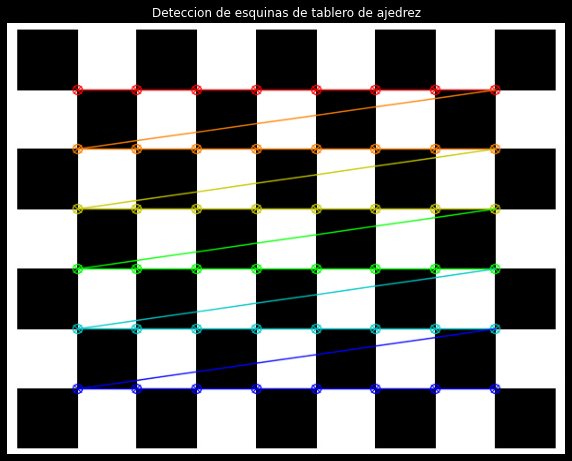

In [18]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
CHESS_BOARD_DIM = (8, 6)

img = cv2.imread('Recursos\Chess.jpg')
img_copy = img.copy()

gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

# Encontrar las esquinas del tablero de ajedrez
ret, corners = cv2.findChessboardCorners(gray, CHESS_BOARD_DIM)

# Si son encontradas, refinar las esquinas y diujarlas en la imagen a color
if ret:
    corners1 = cv2.cornerSubPix(gray, corners, (11, 11), (-1,-1), criteria)
    cv2.drawChessboardCorners(img, CHESS_BOARD_DIM, corners1, ret)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Deteccion de esquinas de tablero de ajedrez')


### Calibración de cámaras con OpenCV

La colección de puntos 3D del mundo real y sus coordenadas 2D en la imagen sirven como datos de entrada clave necesarios para calibrar la cámara. Podemos localizar fácilmente los puntos aceptables de la imagen 2D en la imagen. Estos puntos en un tablero de ajedrez son donde se intersectan dos cuadrados negros.

<center><img src='Recursos\Extrinseco.jpg' width='500'></center>

Para los valores X e Y, podemos simplemente enviar los puntos como $(0, 0)$, $(1, 0)$, $(2, 0)$, etc. para indicar dónde están los puntos. Los resultados en esta situación corresponderán a casillas de un tablero de ajedrez en tamaño. Sin embargo, podemos pasar los valores como $(0, 0)$, $(30, 0)$, $(60, 0)$, etc. si conocemos el tamaño del cuadrado, que es, por ejemplo, 30 mm.

Esto puede ser realizado mediante el siguiente segmento de código:

In [42]:
# tamaño de cuadrado en tablero de ajedrez
SQUARE_SIZE = 14  # milimetros

# preparar los puntos del objeto, como (0,0,0), (1,0,0), (2,0,0) ....,(7,5,0)
obj_3D = np.zeros((CHESS_BOARD_DIM[0] * CHESS_BOARD_DIM[1], 3), np.float32)
obj_3D[:, :2] = np.mgrid[0 : CHESS_BOARD_DIM[0], 0 : CHESS_BOARD_DIM[1]].T.reshape(-1, 2)
obj_3D *= SQUARE_SIZE
print(obj_3D)

[[ 0.  0.  0.]
 [14.  0.  0.]
 [28.  0.  0.]
 [42.  0.  0.]
 [56.  0.  0.]
 [70.  0.  0.]
 [84.  0.  0.]
 [ 0. 14.  0.]
 [14. 14.  0.]
 [28. 14.  0.]
 [42. 14.  0.]
 [56. 14.  0.]
 [70. 14.  0.]
 [84. 14.  0.]
 [ 0. 28.  0.]
 [14. 28.  0.]
 [28. 28.  0.]
 [42. 28.  0.]
 [56. 28.  0.]
 [70. 28.  0.]
 [84. 28.  0.]
 [ 0. 42.  0.]
 [14. 42.  0.]
 [28. 42.  0.]
 [42. 42.  0.]
 [56. 42.  0.]
 [70. 42.  0.]
 [84. 42.  0.]
 [ 0. 56.  0.]
 [14. 56.  0.]
 [28. 56.  0.]
 [42. 56.  0.]
 [56. 56.  0.]
 [70. 56.  0.]
 [84. 56.  0.]]


El siguiente paso es mapear cada punto 3D del tablero a un punto en la imagen, lo cual se puede hacer en base a los puntos encontrados en la función `cv2.findChessboardCorners()` y `cv2.cornerSubPix()`

In [43]:
# Cambiar dimensiones de tablero en base a cual se este utilizando
CHESS_BOARD_DIM = (7, 5)

# Matrices para almacenar los puntos objeto y los puntos imagen de todas las imágenes.
obj_points_3D = []  # Puntos 3D en el espacio del mundo real
img_points_2D = []  # Puntos 2D en el plano de la imagen.

# La ruta del directorio de imágenes
image_dir_path = "images"

files = os.listdir(image_dir_path)
for file in files:
    imagePath = os.path.join(image_dir_path, file)

    image = cv2.imread(imagePath)
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(image, CHESS_BOARD_DIM, None)
    if ret == True:
        obj_points_3D.append(obj_3D)
        corners2 = cv2.cornerSubPix(grayScale, corners, (3, 3), (-1, -1), criteria)
        img_points_2D.append(corners2)

print(img_points_2D)

[array([[[407.52896 , 249.53667 ]],

       [[370.36176 , 249.48187 ]],

       [[333.2281  , 249.23595 ]],

       [[296.3078  , 248.32584 ]],

       [[260.0666  , 247.54588 ]],

       [[225.66388 , 246.39742 ]],

       [[192.88612 , 245.09625 ]],

       [[408.3542  , 211.88802 ]],

       [[370.56625 , 212.04497 ]],

       [[332.83548 , 211.69371 ]],

       [[295.69485 , 211.57385 ]],

       [[259.53983 , 211.22174 ]],

       [[225.22508 , 210.6515  ]],

       [[191.8032  , 210.28337 ]],

       [[408.41562 , 173.69864 ]],

       [[370.46933 , 173.65819 ]],

       [[332.86707 , 173.85867 ]],

       [[295.44437 , 173.99007 ]],

       [[259.15515 , 174.31696 ]],

       [[224.1302  , 174.56389 ]],

       [[190.62773 , 174.97227 ]],

       [[408.0286  , 135.45856 ]],

       [[370.38385 , 135.44604 ]],

       [[332.6469  , 135.60431 ]],

       [[295.39108 , 136.30118 ]],

       [[258.56296 , 137.19006 ]],

       [[223.51526 , 138.26704 ]],

       [[190.23256 , 139.30

In [44]:
print(obj_points_3D)

[array([[ 0.,  0.,  0.],
       [14.,  0.,  0.],
       [28.,  0.,  0.],
       [42.,  0.,  0.],
       [56.,  0.,  0.],
       [70.,  0.,  0.],
       [84.,  0.,  0.],
       [ 0., 14.,  0.],
       [14., 14.,  0.],
       [28., 14.,  0.],
       [42., 14.,  0.],
       [56., 14.,  0.],
       [70., 14.,  0.],
       [84., 14.,  0.],
       [ 0., 28.,  0.],
       [14., 28.,  0.],
       [28., 28.,  0.],
       [42., 28.,  0.],
       [56., 28.,  0.],
       [70., 28.,  0.],
       [84., 28.,  0.],
       [ 0., 42.,  0.],
       [14., 42.,  0.],
       [28., 42.,  0.],
       [42., 42.,  0.],
       [56., 42.,  0.],
       [70., 42.,  0.],
       [84., 42.,  0.],
       [ 0., 56.,  0.],
       [14., 56.,  0.],
       [28., 56.,  0.],
       [42., 56.,  0.],
       [56., 56.,  0.],
       [70., 56.,  0.],
       [84., 56.,  0.]], dtype=float32), array([[ 0.,  0.,  0.],
       [14.,  0.,  0.],
       [28.,  0.,  0.],
       [42.,  0.,  0.],
       [56.,  0.,  0.],
       [70.,  0.,  0.]

#### Calibración
Ahora que tenemos nuestros puntos de objeto y puntos de imagen, estamos listos para ir a la calibración. Podemos utilizar la función, `cv2.calibrateCamera()` que devuelve la matriz de la cámara, los coeficientes de distorsión, los vectores de rotación y traslación, etc.

#### Sintaxis de Función

``` python
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, imageSize, cameraMatrix, distCoeffs, rvecs, tvecs)
```

`cameraMatrix`: Entrada/salida Matriz intrínseca de la cámara en punto flotante 3x3.

$A = \begin{bmatrix}
f_{x} & 0 & c_{x} \\
0 & f_{y} & c_{y} \\
0 & 0 & 1
\end{bmatrix}$<br>

`distCoeffs`: Vector de entrada/salida de los coeficientes de distorsión.
`rvecs`: Vector de salida de los vectores de rotación estimados para cada vista de patrón.
`tvecs`: Vector de salida de los vectores de traslación estimados para cada vista de patrón.


La función tiene **4 argumentos de entrada requeridos**:

<ol>
    <li><code>objectPoints</code>: Vector de vectores de puntos del patrón de calibración en el espacio de coordenadas del patrón de calibración. El vector exterior contiene tantos elementos como el número de vistas del patrón. Si se muestra el mismo patrón de calibración en cada vista y es completamente visible, todos los vectores serán iguales. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>imagePoints</code>: Vector de vectores de las proyecciones de los puntos del patrón de calibración. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>cameraMatrix</code>: Entrada/salida Matriz intrínseca de la cámara en punto flotante 3x3.. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>distCoeffs</code>: Vector de entrada/salida de los coeficientes de distorsión. Es un argumento <b>obligatorio</b>.
</ol>

In [45]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points_3D, img_points_2D, grayScale.shape[::-1], None, None)

Se observan los parametros intrínsecos obtenidos por la calibración:

In [52]:
# matriz de parametros intrinsecos de la cámara
print(mtx)

[[491.19243862   0.         317.4583139 ]
 [  0.         492.26299859 194.31160659]
 [  0.           0.           1.        ]]


#### Desdistorsión

Ahora, podemos tomar una imagen y distorsionarla. Primero, podemos refinar la matriz de la cámara basada en un parámetro de escala libre usando `cv2.getOptimalNewCameraMatrix()`. Si el parámetro de escala alpha=0, devuelve una imagen no distorsionada con un mínimo de píxeles no deseados. Así que puede incluso eliminar algunos píxeles en las esquinas de la imagen. Si alpha=1, se conservan todos los píxeles con algunas imágenes negras adicionales. Esta función también devuelve una imagen ROI que puede utilizarse para recortar el resultado.

#### Sintaxis de Función

``` python
retval, validPixROI = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, imageSize, alpha, newImgSize)
```

`validPixROI`: Entrada/salida Matriz intrínseca de la cámara en punto flotante 3x3.


La función tiene **5 argumentos de entrada requeridos**:

<ol>
    <li><code>cameraMatrix</code>: Matriz intrínseca de la cámara de entrada. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>distCoeffs</code>: Vector de entrada de los coeficientes de distorsión. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>imageSize</code>: Tamaño original de la imagen. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>alpha</code>: Parámetro de escala libre entre 0 (cuando todos los píxeles de la imagen no distorsionada son válidos) y 1 (cuando todos los píxeles de la imagen de origen se conservan en la imagen no distorsionada). Es un argumento <b>obligatorio</b>.
    <li><code>newImgSize</code>: Tamaño de la imagen después de la rectificación. Por defecto, se establece en <code>imageSize</code>. Es un argumento <b>obligatorio</b>.
    <br>
</ol>

In [53]:
img_dist = cv2.imread('images\image0.png')
h,  w = img_dist.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

Se observan los nuevos parámetros intrínsecos obtenidos por la función:

In [56]:
# nueva matriz de parametros intrinsecos de la cámara
print(newcameramtx)

[[424.36828613   0.         315.49601461]
 [  0.         425.02902222 195.28500843]
 [  0.           0.           1.        ]]


Ahora, es posible corregir la distorción mediante el uso de la función `cv2.undistort()`. Esta es la forma más sencilla. Basta con llamar a la función y utilizar la ROI obtenido anteriormente para recortar el resultado.

#### Sintaxis de Función

``` python
dst = cv2.undistort(src, cameraMatrix, distCoeffs, newCameraMatrix)
```

`dst`: Imagen de salida (corregida) que tiene el mismo tamaño y tipo que src.


La función tiene **3 argumentos de entrada requeridos** y **1 argumento opcional**:

<ol>
    <li><code>src</code>: Imagen de entrada (distorsionada). Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>cameraMatrix</code>: Matriz de la cámara de entrada. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>distCoeffs</code>: Vector de entrada de los coeficientes de distorsión. Es un argumento <b>obligatorio</b>.
    <br>
    <li><code>newCameraMatrix</code>: Matriz de cámara de la imagen distorsionada. Por defecto, es la misma que <code>cameraMatrix</code>, pero puede escalar y desplazar adicionalmente el resultado utilizando una matriz diferente.
</ol>

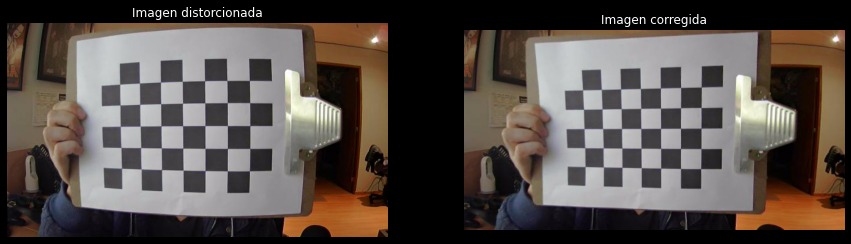

In [59]:
# corregir distorcion
dst = cv2.undistort(img_dist, mtx, dist, None, newcameramtx)

# recortar la imagen
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
imagenes = [img_dist, dst]
titulos = ['Imagen distorcionada', 'Imagen corregida']
plot_img(imagenes, titulos)

## Ejercicios

<ol>
<li>
Diseñar un programa en Python en el cual se cumplan los siguientes requisitos:
    <ul>
    <li>Acceder a una camara web.
    <li>Encontrar las esquinas de un tablero de ajedrez y mostrar el patrón encontrado mediante el uso de la función <code>cv2.findChessboardCorners()</code>.
    <li>Si se encuentra el patrón de tablero de ajedrez, permitir guardar las imagenes para la calibración de cámara.
    </ul>
</li>
<br>

<li>
Diseñar un programa en Python en el cual se cumplan los siguientes requisitos:
    <ul>
    <li>Usando las imagenes anteriormente capturadas, encontrar los parámteros extrínsecos de la cámara web.
    <li>Encontrar los tipos de distorciones en la cámara.
    <li>Guardar los parámteros para su corrección.
    </ul>
</li>

<li>
Diseñar un programa en Python en el cual se cumplan los siguientes requisitos:
    <ul>
    <li>Acceder a la cámara web.
    <li>Con los parámetros encontrados y guardados, realizar la correción de distorisión.
    <li>Mostrar el video con la distorción y resultado al aplicar la corrección.
    </ul>
</li>
</ol>